In [13]:
%matplotlib inline
#manipulation
import numpy as np
import pandas as pd
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
#preprocessing
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
#ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

In [14]:
train=pd.read_csv("data/train.csv")
test=pd.read_csv("data/test.csv")
sample_submission=pd.read_csv("data/sample_submission.csv")

In [15]:
#Drop Id and create a total data set
train_id = train['Id']
test_id = test['Id']
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
total=train.append(test)

In [17]:
missing=(total.isnull().sum() / len(total)) *100
missing=missing.drop(missing[missing==0].index).sort_values(ascending=False)
missing=pd.DataFrame({'Missing Ratio' :missing})
missing.head(40)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
SalePrice,49.982871
FireplaceQu,48.646797
LotFrontage,16.649538
GarageYrBlt,5.447071
GarageFinish,5.447071
GarageQual,5.447071


In [18]:
total['PoolQC'] = total['PoolQC'].fillna('None')
total['MiscFeature'] = total['MiscFeature'].fillna('None')
total['Alley'] = total['Alley'].fillna('None')
total['Fence'] = total['Fence'].fillna('None')
total['FireplaceQu'] = total['FireplaceQu'].fillna('None')

In [19]:
total['FireplaceQu'] = total['FireplaceQu'].fillna('None')
for feat in ('GarageType', 'GarageFinish', 'GarageCond'):
    total[feat] = total[feat].fillna('None')
for feat in ('GarageArea', 'GarageCars', 'GarageYrBlt', 'GarageQual'):
    total[feat] = total[feat].fillna(0)

In [20]:
for feat in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    total[feat] = total[feat].fillna('None')
for feat in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF'):
    total[feat] = total[feat].fillna(0)

In [21]:
total['MasVnrType'] = total['MasVnrType'].fillna('None')
total['MasVnrArea'] = total['MasVnrArea'].fillna(0)
total['Functional'] = total['Functional'].fillna('Typical')
#guessing that NA means no building class
total['MSSubClass'] = total['MSSubClass'].fillna('None')

In [22]:
for feat in ('MSZoning', 'Utilities', 'KitchenQual', 'SaleType', 'Exterior1st', 'Exterior2nd', 'Electrical'):
    total[feat] = total[feat].fillna(total[feat].mode()[0])

In [23]:
total['LotFrontage'] = total.groupby('Neighborhood')['LotFrontage'].transform(lambda i: i.fillna(i.mean()))

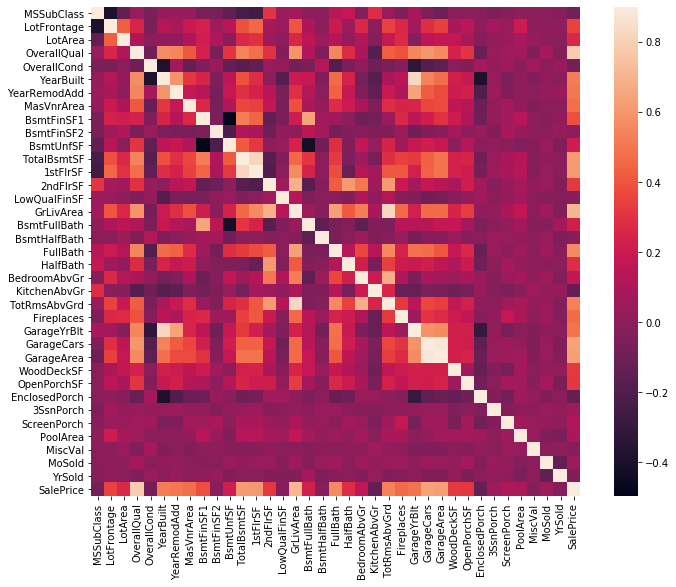

In [25]:
corr = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr, vmax=0.9, square=True)
plt.show()

In [26]:
print(total['MSSubClass'].dtype)

int64


In [27]:
total['MSSubClass']=total['MSSubClass'].apply(str)

In [28]:
print(total['MSSubClass'].dtype)

object


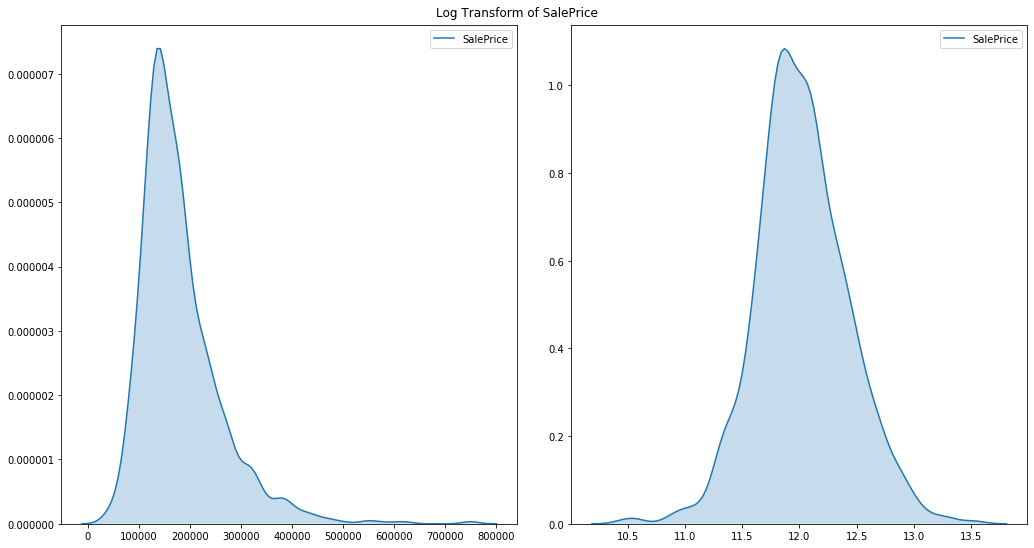

In [29]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.kdeplot(train['SalePrice'], shade=True, ax=ax[0])
sns.kdeplot(np.log1p(train["SalePrice"]), shade=True, ax=ax[1])
plt.suptitle('Log Transform of SalePrice')
fig.tight_layout(pad=3.0)

In [31]:
numeric_feats=total.dtypes[total.dtypes!="object"].index
#Calculate the skewness of the variables
skewed_feats=total[numeric_feats].apply(lambda i: skew(i.dropna()))
skewed_feats=skewed_feats[skewed_feats>0.75]
skewed_feats=skewed_feats.index
#log transform all numeric features
total[skewed_feats]=np.log1p(total[skewed_feats])

In [32]:
#Encoding categorical variables
total=pd.get_dummies(total)
total.shape

(2919, 319)

In [40]:
#import necessary libraries for machine learning
from sklearn.linear_model import LassoCV, ElasticNet, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

Note: you may need to restart the kernel to use updated packages.


In [42]:
#Split total into train and test
train=total[:len(train)]
test=total[len(train):]

#Split training data for machine learning purposes
X_train = train.drop('SalePrice', axis = 1)
y_train = train['SalePrice']
X_test=test.drop('SalePrice', axis=1)
#Standardize data with robust scaler, because it is more robust to outliers than standards scaling
X_train=preprocessing.RobustScaler().fit(X_train).transform(X_train)
X_test=preprocessing.RobustScaler().fit(X_test).transform(X_test)

In [43]:
#Define cv RMSE function to evaluate the accuracty of our algorithms
def rmse_cv(model):
    rmse=np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [53]:
#print mean and std
def print_model_stats(model):
    print("RMSE: ", rmse_cv(model).mean(), "STD:", rmse_cv(model).std())

In [54]:
X_train.shape

(1460, 318)

In [55]:
#1. Regression models
#RidgeCV
model_ridge=RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 70]).fit(X_train, y_train)
print_model_stats(model_ridge)

RMSE:  0.12658095175568257 STD: 0.014981250300351964


In [57]:
#LassoCV
model_lasso=LassoCV(alphas=[0.1, 0.001, 0.0005]).fit(X_train, y_train)
print_model_stats(model_lasso)

RMSE:  0.12262384575452705 STD: 0.015724858449651172


In [58]:
#ElasticNet
model_enet=ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3).fit(X_train, y_train)
print_model_stats(model_enet)

RMSE:  0.12271424148640779 STD: 0.01574314142461746


In [59]:
#SVR
model_svr=SVR(C=20, epsilon=0.008, gamma=0.0003).fit(X_train, y_train)
print_model_stats(model_svr)

RMSE:  0.12327073280129178 STD: 0.01905143256901432


In [61]:
#2.Ensemble Models
#XGBoost
model_xgb=xgb.XGBRegressor(eta=.05, n_estimators=1000, max_depth=3, min_child_weight=4, learning_rate=0.1).fit(X_train, y_train)
print_model_stats(model_xgb)

RMSE:  0.12371106838865382 STD: 0.009642534870074193


In [62]:
#GradientBoosting
model_gboost=GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=10,
                                      loss='huber', random_state=5)
model_gboost.fit(X_train, y_train)
print_model_stats(model_gboost)

RMSE:  0.1249381968439814 STD: 0.012294920497425872


In [66]:
#LightGBM
model_lgbm=lgb.LGBMRegressor(objective='regression',                                       
                                        num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                      bagging_freq=5, 
                                      bagging_seed=7,
                                      feature_fraction=0.2,
                                      feature_fraction_seed=7,
                                      verbose=-1)
model_lgbm.fit(X_train, y_train)
print_model_stats(model_lgbm)

RMSE:  0.12251555153662982 STD: 0.009219931027869213


In [67]:
#Performance of Averaged Models
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y_train, train_pred))

In [68]:
enet_pred_train = model_enet.predict(X_train)
ridge_pred_train = model_ridge.predict(X_train)
lasso_pred_train = model_lasso.predict(X_train)
svr_pred_train = model_svr.predict(X_train)
xgb_pred_train = model_xgb.predict(X_train)
gboost_pred_train = model_gboost.predict(X_train)
lgbm_pred_train = model_lgbm.predict(X_train)

In [69]:
#compute rmse of optimal mix
train_pred = .5*lasso_pred_train +.45*svr_pred_train + .05*enet_pred_train
print(rmse(y_train, train_pred))

0.10341479481828943


In [70]:
#add ensemble
train_pred = .35*lasso_pred_train +.3*svr_pred_train + .05*enet_pred_train + .1*gboost_pred_train +.1*xgb_pred_train + .1*lgbm_pred_train
print(rmse(y_train, train_pred))

0.08574721751368636


In [71]:
#adjust weights
train_pred = .35*lasso_pred_train +.25*svr_pred_train + .05*enet_pred_train + .15*gboost_pred_train +.1*xgb_pred_train + .1*lgbm_pred_train
print(rmse(y_train, train_pred))

0.08291584419585095


In [72]:
ridge_pred = model_ridge.predict(X_test)
ridge_pred = np.expm1(ridge_pred)
lasso_pred = model_lasso.predict(X_test)
lasso_pred = np.expm1(lasso_pred)
enet_pred = model_enet.predict(X_test)
enet_pred = np.expm1(enet_pred)
svr_pred = model_svr.predict(X_test)
svr_pred = np.expm1(svr_pred)
xgb_pred = model_xgb.predict(X_test)
xgb_pred = np.expm1(xgb_pred)
gboost_pred = model_gboost.predict(X_test)
gboost_pred = np.expm1(gboost_pred)
lgbm_pred = model_lgbm.predict(X_test)
lgbm_pred = np.expm1(lgbm_pred)

In [73]:
pred = .2*enet_pred + .6*svr_pred + .05*xgb_pred + .05*gboost_pred + .1*lgbm_pred #best so far

#to test
#pred = .5*lasso_pred +.45*svr_pred + .05*enet_pred #.1227
#pred = .3*xgb_pred + .3*gboost_pred + .4*lgbm_pred #.127
#pred = .35*lasso_pred+.3*svr_pred + .05*enet_pred + .1*gboost_pred +.1*xgb_pred + .1*lgbm_pred #.125
#pred = .35*lasso_pred +.25*svr_pred + .05*enet_pred + .15*gboost_pred +.1*xgb_pred + .1*lgbm_pred

In [76]:
# create dataframe that resembles what we are to submit to kaggle
submission = pd.DataFrame()
submission['Id'] = test_id
#add predictions
submission['SalePrice'] = lgbm_pred
submission.head()

,Id,SalePrice
0,1461,123899.359696
1,1462,163765.111525
2,1463,185792.049491
3,1464,199012.522359
4,1465,202750.620943


In [77]:
#save final predictions to a csv file
submission.to_csv('submission.csv', index=False)
print("Submission has been saved")

Submission has been saved
